In [ ]:
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPool2D, Activation, BatchNormalization, Flatten, InputLayer, Input, GlobalAveragePooling2D, Dropout
from keras.utils import to_categorical
from keras.optimizers import SGD
from keras.models import load_model
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pickle

from keras.preprocessing import image
import random
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, average_precision_score, confusion_matrix, precision_recall_curve, auc
from keras import backend as K
from keras.layers.core import Lambda
from keras.callbacks import ModelCheckpoint, TensorBoard
from itertools import combinations

Load the dataset

In [ ]:
def load_data():

      filenames = os.listdir('/content/drive/My Drive/Market/')
      x = []
      labels = []

      j=0
      for filename in filenames:
        x += [cv2.imread(os.path.join(os.path.abspath('/content/drive/My Drive/Market/'), filename), cv2.IMREAD_UNCHANGED)]
        labels += [int(filename[:4])]
        j +=1
        print(j)

      for i in range(len(x)):
        x[i] = cv2.resize(x[i], (128,128), interpolation=cv2.INTER_LINEAR).astype('uint8')
        print(i)

      return x, labels

In [ ]:
x, labels = load_data()

idx = np.argsort(labels)
x = np.array(x)[idx]
labels = np.array(labels)[idx]

In [ ]:
pickle_out = open("/content/drive/My Drive/Data/Market/x.pickle","wb")
pickle.dump(x, pickle_out)
pickle_out.close()

pickle_out = open("/content/drive/My Drive/Data/Market/labels.pickle","wb")
pickle.dump(labels, pickle_out)
pickle_out.close()

In [ ]:
pickle_in = open("/content/drive/My Drive/Data/Market/x.pickle","rb")
x = pickle.load(pickle_in)

pickle_in = open("/content/drive/My Drive/Data/Market/labels.pickle","rb")
labels = pickle.load(pickle_in)

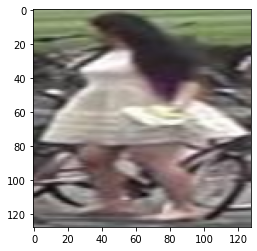

person 1


In [ ]:
plt.imshow(cv2.cvtColor(x[0], cv2.COLOR_BGR2RGB))
plt.show()
print('person', labels[0])

Train the MobileNet - Classification

In [ ]:
def base_model():

    mobilenet = keras.applications.mobilenet.MobileNet(input_shape=(128,128,3), weights="imagenet", include_top=False)

    model = Sequential()
    model.add(mobilenet)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1502, activation='softmax'))

    return model

In [ ]:
def train_valid_split(x,labels):
  
  x_classes = []
  labels_classes = []

  for j in range(1, 1502):
    aux_x = []
    aux_labels = []
    for i in range(len(labels)):
      if labels[i] == j:
        aux_x.append(x[i])
        aux_labels.append(labels[i])
    x_classes.append(aux_x)
    labels_classes.append(aux_labels)
  
  x_train = []
  labels_train = []
  x_valid = []
  labels_valid = []

  for i in range(len(x_classes)):
    aux_x_t, aux_x_v, aux_labels_t, aux_labels_v = train_test_split(x_classes[i], labels_classes[i], test_size=0.33)

    for a in range(len(aux_x_t)):
      x_train.append(aux_x_t[a])
      labels_train.append(aux_labels_t[a])

    for b in range(len(aux_x_v)):
      x_valid.append(aux_x_v[b])
      labels_valid.append(aux_labels_v[b])

  x_train = np.array(x_train)
  labels_train = np.array(labels_train)
  x_valid = np.array(x_valid)
  labels_valid = np.array(labels_valid)

  return x_train, labels_train, x_valid, labels_valid

In [ ]:
x_train, labels_train, x_valid, labels_valid = train_valid_split(x,labels)

aux = np.arange(labels_train.shape[0])
np.random.shuffle(aux)
x_train = x_train[aux]
labels_train = labels_train[aux]

aux = np.arange(labels_valid.shape[0])
np.random.shuffle(aux)
x_valid = x_valid[aux]
labels_valid = labels_valid[aux]

labels_train = to_categorical(labels_train, num_classes=1502)
labels_valid = to_categorical(labels_valid, num_classes=1502)

In [ ]:
pickle_out = open("/content/drive/My Drive/Data/Market/x_train.pickle","wb")
pickle.dump(x_train, pickle_out)
pickle_out.close()

pickle_out = open("/content/drive/My Drive/Data/Market/labels_train.pickle","wb")
pickle.dump(labels_train, pickle_out)
pickle_out.close()

pickle_out = open("/content/drive/My Drive/Data/Market/x_valid.pickle","wb")
pickle.dump(x_valid, pickle_out)
pickle_out.close()

pickle_out = open("/content/drive/My Drive/Data/Market/labels_valid.pickle","wb")
pickle.dump(labels_valid, pickle_out)
pickle_out.close()

In [ ]:
pickle_in = open("/content/drive/My Drive/Data/Market/x_train.pickle","rb")
x_train = pickle.load(pickle_in)

pickle_in = open("/content/drive/My Drive/Data/Market/labels_train.pickle","rb")
labels_train = pickle.load(pickle_in)

pickle_in = open("/content/drive/My Drive/Data/Market/x_valid.pickle","rb")
x_valid = pickle.load(pickle_in)

pickle_in = open("/content/drive/My Drive/Data/Market/labels_valid.pickle","rb")
labels_valid = pickle.load(pickle_in)

In [ ]:
model = base_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_128 (Function (None, 4, 4, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1049600   
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1502)              1539550   
Total params: 6,867,614
Trainable params: 6,845,726
Non-trainable params: 21,888
_________________________________________

In [ ]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)

opt = keras.optimizers.SGD(learning_rate=lr_schedule)

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics = ['accuracy'])

callbacks = ModelCheckpoint('/content/drive/My Drive/Results/Market/MobileNet_Class_shuffle.h5', monitor='val_loss', verbose=2, save_best_only=True, save_weights_only=False, mode='auto')

results = model.fit(x_train, labels_train, batch_size=32, epochs=500, steps_per_epoch=20, callbacks = callbacks, validation_data=(x_valid, labels_valid))

Epoch 1/500
20/20 [==============================] - ETA: 0s - loss: 7.5177 - accuracy: 0.0016
Epoch 00001: val_loss improved from inf to 7.39814, saving model to /content/drive/My Drive/Results/Market/MobileNet_Class_shuffle.h5
20/20 [==============================] - 5s 252ms/step - loss: 7.5177 - accuracy: 0.0016 - val_loss: 7.3981 - val_accuracy: 3.3670e-04
Epoch 2/500
20/20 [==============================] - ETA: 0s - loss: 7.4617 - accuracy: 0.0000e+00
Epoch 00002: val_loss improved from 7.39814 to 7.37850, saving model to /content/drive/My Drive/Results/Market/MobileNet_Class_shuffle.h5
20/20 [==============================] - 5s 226ms/step - loss: 7.4617 - accuracy: 0.0000e+00 - val_loss: 7.3785 - val_accuracy: 8.9787e-04
Epoch 3/500
20/20 [==============================] - ETA: 0s - loss: 7.3870 - accuracy: 0.0016
Epoch 00003: val_loss improved from 7.37850 to 7.35442, saving model to /content/drive/My Drive/Results/Market/MobileNet_Class_shuffle.h5
20/20 [====================

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


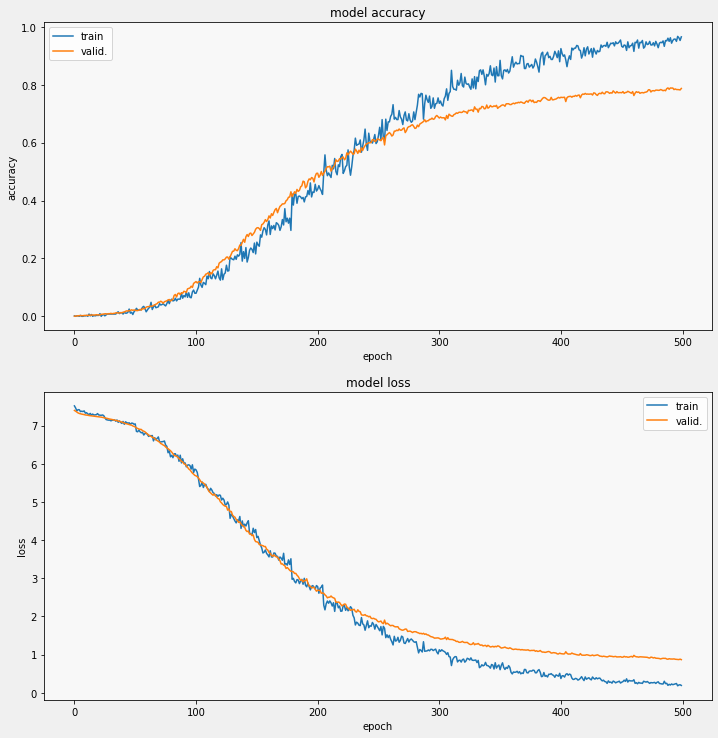

In [ ]:
def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])


print(results.history.keys())
display_training_curves(results.history['accuracy'], results.history['val_accuracy'], 'accuracy', 211)
display_training_curves(results.history['loss'], results.history['val_loss'], 'loss', 212)

-----------------RE-ID PART--------------------

In [ ]:
def divide_data_reid_open(x,labels):
  
  data_train = []
  labels_train = []

  data_valid = []
  labels_valid = []

  for i in range(len(labels)):
    if labels[i] < 920:
      data_train.append(x[i])
      labels_train.append(labels[i])
    else:
      data_valid.append(x[i])
      labels_valid.append(labels[i])

  data_train = np.array(data_train)
  data_valid = np.array(data_valid)
  labels_train = np.array(labels_train)
  labels_valid = np.array(labels_valid)

  return data_train, labels_train, data_valid, labels_valid

In [ ]:
def divide_data_reid_close(x,labels):
  
  x_classes = []
  labels_classes = []

  for j in range(1, 1502):
    aux_x = []
    aux_labels = []
    for i in range(len(labels)):
      if labels[i] == j:
        aux_x.append(x[i])
        aux_labels.append(labels[i])
    x_classes.append(aux_x)
    labels_classes.append(aux_labels)
  
  data_train = []
  labels_train = []
  data_valid = []
  labels_valid = []

  for i in range(len(x_classes)):
    aux_x_t, aux_x_v, aux_labels_t, aux_labels_v = train_test_split(x_classes[i], labels_classes[i], test_size=0.33)

    for a in range(len(aux_x_t)):
      data_train.append(aux_x_t[a])
      labels_train.append(aux_labels_t[a])

    for b in range(len(aux_x_v)):
      data_valid.append(aux_x_v[b])
      labels_valid.append(aux_labels_v[b])

  data_train = np.array(data_train)
  data_valid = np.array(data_valid)
  labels_train = np.array(labels_train)
  labels_valid = np.array(labels_valid)

  return data_train, labels_train, data_valid, labels_valid

In [ ]:
def l1_distance(inputs):
    input1, input2 = inputs
    #print(input1.shape, input2.shape)
    output = K.abs(input1 - input2)
    #print(output.shape)
    return output


def l1_distance_output_shape(shapes):
    shape1, shape2 = shapes
    assert shape1 == shape2
    return (1,)

In [ ]:
def get_mobile_net(x):

	model = load_model('/content/drive/My Drive/Results/Market/MobileNet_Class_shuffle.h5')
	new_model = Model(model.input, model.layers[-3].output)
	
	new_model.summary()
	
	feature_vectors = []

	i=0
	for xi in x:
		feature_vectors.append(new_model.predict(np.expand_dims(xi, axis=0)))
		i+=1
		print(i)
	
	for j in range(len(feature_vectors)):
		feature_vectors[j] = feature_vectors[j][0]
	
	feature_vectors = np.array(feature_vectors)

	return feature_vectors

In [ ]:
feat_vect = get_mobile_net(x)

In [ ]:
pickle_out = open("/content/drive/My Drive/Data/Market/feat_vect.pickle","wb")
pickle.dump(feat_vect, pickle_out)
pickle_out.close()

In [ ]:
pickle_in = open("/content/drive/My Drive/Data/Market/feat_vect.pickle","rb")
feat_vect = pickle.load(pickle_in)

In [ ]:
def siamese_model():
   
    input1 = Input(shape=(2048,))
    dense_layer = Dense(1024, activation='relu')(input1)
    dense_layer = Dense(512, activation='relu')(dense_layer)
    dense_layer = Dense(256, activation='relu')(dense_layer)    
    dense_layer = Dense(10, activation='relu')(dense_layer)
    output = Dense(1, activation='sigmoid')(dense_layer)

    return Model(inputs=input1, outputs=output)

def siamese_model_1024():
   
    input1 = Input(shape=(1024,))
    input2 = Input(shape=(1024,))
    distance = Lambda(l1_distance, output_shape=l1_distance_output_shape)([input1, input2])    
    dense_layer = Dense(1024, activation='relu')(distance)
    dense_layer = Dense(1024, activation='relu')(dense_layer)
    dense_layer = Dense(512, activation='relu')(dense_layer)
    dense_layer = Dense(256, activation='relu')(dense_layer)
    dense_layer = Dense(10, activation='relu')(dense_layer)
    output = Dense(1, activation='sigmoid')(dense_layer)

    return Model(inputs=[input1, input2], outputs=output)

In [ ]:
def create_pairs_close(x, labels):

    input1 = []
    input2 = []
    pair_labels = []

    #create all positive pairs
    for i in range(len(x)):
      for j in range(len(x)):
        if i < j:
          if labels[i] == labels[j]:
            label = 1
            input1 += [x[i]]
            input2 += [x[j]]
            pair_labels += [label]

    num_pos = len(pair_labels)/len(labels)

    for i in range(len(x)):
      neg_per_image = 0
      for j in range(len(x)):
        if i < j:
          if labels[i] != labels[j] and neg_per_image < num_pos:
            label = 0
            input1 += [x[i]]
            input2 += [x[j]]
            pair_labels += [label]
            neg_per_image += 1

    c = list(zip(input1, input2, pair_labels))
    random.shuffle(c)
    input1, input2, pair_labels = zip(*c)

    input1 = np.array(input1)
    input2 = np.array(input2)
    pair_labels = np.array(pair_labels)

    return input1, input2, pair_labels

In [ ]:
def create_pairs_open(x, labels):

    input1 = []
    input2 = []
    pair_labels = []
    input1_ = []
    input2_ = []
    pair_labels_ = []

    #create all positive pairs
    for i in range(len(x)):
      for j in range(len(x)):
        if i < j:
          if labels[i] == labels[j]:
            label = 1
            input1 += [x[i]]
            input2 += [x[j]]
            pair_labels += [label]

    c = list(zip(input1, input2, pair_labels))
    random.shuffle(c)
    input1, input2, pair_labels = zip(*c)

    input1 = input1[:35625]
    input2 = input2[:35625]
    pair_labels = pair_labels[:35625]

    num_pos = len(pair_labels)/len(labels)
    print(num_pos)

    for i in range(len(x)):
      neg_per_image = 0
      for j in range(len(x)):
        if i < j:
          if labels[i] != labels[j] and neg_per_image < num_pos:
            label = 0
            input1_ += [x[i]]
            input2_ += [x[j]]
            pair_labels_ += [label]
            neg_per_image += 1

    c = list(zip(input1_, input2_, pair_labels_))
    random.shuffle(c)
    input1_, input2_, pair_labels_ = zip(*c)

    input1_ = input1_[:30037]
    input2_ = input2_[:30037]
    pair_labels_ = pair_labels_[:30037]

    input1 = input1+input1_
    input2 = input2+input2_
    pair_labels = pair_labels+pair_labels_

    c = list(zip(input1, input2, pair_labels))
    random.shuffle(c)
    input1, input2, pair_labels = zip(*c)

    input1 = np.array(input1)
    input2 = np.array(input2)
    pair_labels = np.array(pair_labels)

    return input1, input2, pair_labels

In [ ]:
# CREATE DATA FOR OPEN WORLD
data_train, labels_train, data_valid, labels_valid = divide_data_reid_open(feat_vect,labels)
i1_train, i2_train, pair_labels_train = create_pairs_open(data_train, labels_train)
i1_valid, i2_valid, pair_labels_valid = create_pairs_open(data_valid, labels_valid)

i_train = []
i_valid = []

for i in range(len(i1_train)):
  i_train.append(np.concatenate((i1_train[i], i2_train[i]), axis=None))

for i in range(len(i1_valid)):
  i_valid.append(np.concatenate((i1_valid[i], i2_valid[i]), axis=None))

i_train = np.array(i_train)
i_valid = np.array(i_valid)

2.1383553421368546
4.13811127889418


In [ ]:
# SAVE TRAIN AND VALID FOR OPEN-WORLD
pickle_out = open("/content/drive/My Drive/Data/Market/i_train_open.pickle","wb")
pickle.dump(i_train, pickle_out)
pickle_out.close()

pickle_out = open("/content/drive/My Drive/Data/Market/pair_labels_train_open.pickle","wb")
pickle.dump(pair_labels_train, pickle_out)
pickle_out.close()

pickle_out = open("/content/drive/My Drive/Data/Market/i1_train_open.pickle","wb")
pickle.dump(i1_train, pickle_out)
pickle_out.close()

pickle_out = open("/content/drive/My Drive/Data/Market/i2_train_open.pickle","wb")
pickle.dump(i2_train, pickle_out)
pickle_out.close()

pickle_out = open("/content/drive/My Drive/Data/Market/i_valid_open.pickle","wb")
pickle.dump(i_valid, pickle_out)
pickle_out.close()

pickle_out = open("/content/drive/My Drive/Data/Market/pair_labels_valid_open.pickle","wb")
pickle.dump(pair_labels_valid, pickle_out)
pickle_out.close()

pickle_out = open("/content/drive/My Drive/Data/Market/i1_valid_open.pickle","wb")
pickle.dump(i1_valid, pickle_out)
pickle_out.close()

pickle_out = open("/content/drive/My Drive/Data/Market/i2_valid_open.pickle","wb")
pickle.dump(i2_valid, pickle_out)
pickle_out.close()

In [ ]:
# GET DATA FOR OPEN WORLD

pickle_in = open("/content/drive/My Drive/Data/Market/i_train_open.pickle","rb")
i_train = pickle.load(pickle_in)

pickle_in = open("/content/drive/My Drive/Data/Market/pair_labels_train_open.pickle","rb")
pair_labels_train = pickle.load(pickle_in)

pickle_in = open("/content/drive/My Drive/Data/Market/i1_train_open.pickle","rb")
i1_train = pickle.load(pickle_in)

pickle_in = open("/content/drive/My Drive/Data/Market/i2_train_open.pickle","rb")
i2_train = pickle.load(pickle_in)

pickle_in = open("/content/drive/My Drive/Data/Market/i_valid_open.pickle","rb")
i_valid = pickle.load(pickle_in)

pickle_in = open("/content/drive/My Drive/Data/Market/pair_labels_valid_open.pickle","rb")
pair_labels_valid = pickle.load(pickle_in)

pickle_in = open("/content/drive/My Drive/Data/Market/i1_valid_open.pickle","rb")
i1_valid = pickle.load(pickle_in)

pickle_in = open("/content/drive/My Drive/Data/Market/i2_valid_open.pickle","rb")
i2_valid = pickle.load(pickle_in)

In [ ]:
# CREATE DATA FOR CLOSE WORLD

data_train, labels_train, data_valid, labels_valid = divide_data_reid_close(feat_vect,labels)
i1_train, i2_train, pair_labels_train = create_pairs_(data_train, labels_train)
i1_valid, i2_valid, pair_labels_valid = create_pairs_(data_valid, labels_valid)

print('ihd')
i_train = []
i_valid = []

for i in range(len(i1_train)):
  i_train.append(np.concatenate((i1_train[i], i2_train[i]), axis=None))

for i in range(len(i1_valid)):
  i_valid.append(np.concatenate((i1_valid[i], i2_valid[i]), axis=None))

i_train = np.array(i_train)
i_valid = np.array(i_valid)

In [ ]:
data_train, labels_train, data_valid, labels_valid = divide_data_reid_close(feat_vect,labels)


In [ ]:
# SAVE TRAIN AND VALID FOR CLOSE-WORLD

pickle_out = open("/content/drive/My Drive/Data/Market/i_train_close.pickle","wb")
pickle.dump(i_train, pickle_out)
pickle_out.close()

pickle_out = open("/content/drive/My Drive/Data/Market/pair_labels_train_close.pickle","wb")
pickle.dump(pair_labels_train, pickle_out)
pickle_out.close()

pickle_out = open("/content/drive/My Drive/Data/Market/i1_train_close.pickle","wb")
pickle.dump(i1_train, pickle_out)
pickle_out.close()

pickle_out = open("/content/drive/My Drive/Data/Market/i2_train_close.pickle","wb")
pickle.dump(i2_train, pickle_out)
pickle_out.close()

pickle_out = open("/content/drive/My Drive/Data/Market/i_valid_close.pickle","wb")
pickle.dump(i_valid, pickle_out)
pickle_out.close()

pickle_out = open("/content/drive/My Drive/Data/Market/pair_labels_valid_close.pickle","wb")
pickle.dump(pair_labels_valid, pickle_out)
pickle_out.close()

pickle_out = open("/content/drive/My Drive/Data/Market/i1_valid_close.pickle","wb")
pickle.dump(i1_valid, pickle_out)
pickle_out.close()

pickle_out = open("/content/drive/My Drive/Data/Market/i2_valid_close.pickle","wb")
pickle.dump(i2_valid, pickle_out)
pickle_out.close()

In [ ]:
# GET DATA FOR CLOSE WORLD

pickle_in = open("/content/drive/My Drive/Data/Market/i_train_close.pickle","rb")
i_train = pickle.load(pickle_in)

print('1')

pickle_in = open("/content/drive/My Drive/Data/Market/pair_labels_train_close.pickle","rb")
pair_labels_train = pickle.load(pickle_in)
print('1')

pickle_in = open("/content/drive/My Drive/Data/Market/i1_train_close.pickle","rb")
i1_train = pickle.load(pickle_in)
print('1')

pickle_in = open("/content/drive/My Drive/Data/Market/i2_train_close.pickle","rb")
i2_train = pickle.load(pickle_in)
print('1')

pickle_in = open("/content/drive/My Drive/Data/Market/i_valid_close.pickle","rb")
i_valid = pickle.load(pickle_in)
print('1')

pickle_in = open("/content/drive/My Drive/Data/Market/pair_labels_valid_close.pickle","rb")
pair_labels_valid = pickle.load(pickle_in)
print('1')

pickle_in = open("/content/drive/My Drive/Data/Market/i1_valid_close.pickle","rb")
i1_valid = pickle.load(pickle_in)
print('1')

pickle_in = open("/content/drive/My Drive/Data/Market/i2_valid_close.pickle","rb")
i2_valid = pickle.load(pickle_in)

1
1
1
1
1
1
1


In [ ]:
i_train = i_train[:2000]
i1_train = i1_train[:2000]
i2_train = i2_train[:2000]
pair_labels_train = pair_labels_train[:2000]

i_valid = i_valid[:2000]
i1_valid = i1_valid[:2000]
i2_valid = i2_valid[:2000]
pair_labels_valid = pair_labels_valid[:2000]

In [ ]:
model = siamese_model()

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)

opt = keras.optimizers.SGD(learning_rate=lr_schedule)

model.compile(loss='binary_crossentropy', optimizer=opt, metrics = ['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2048)]            0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                2570      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 2,756,885
Trainable params: 2,756,885
Non-trainable params: 0
___________________________________________________

In [ ]:
callbacks = ModelCheckpoint('/content/drive/My Drive/Results/Market/ihdn.h5', monitor='val_loss', verbose=2, save_best_only=True, save_weights_only=False, mode='auto')

In [ ]:
#2048 input
reid_results = model.fit(i_train, pair_labels_train, batch_size=32, steps_per_epoch=20, epochs=200, verbose=2, validation_data=(i_valid, pair_labels_valid), callbacks=callbacks)


#1024 input
#reid_results = model.fit([i1_train, i2_train], pair_labels_train, epochs=200, verbose=2, validation_data=([i1_valid, i2_valid], pair_labels_valid), callbacks=callbacks)

Epoch 1/200
20/20 - 15s - loss: 0.6368 - accuracy: 0.6328 - val_loss: 0.6181 - val_accuracy: 0.6564

Epoch 00001: val_loss improved from 0.64981 to 0.61812, saving model to /content/drive/My Drive/Results/Market/ihdn.h5
Epoch 2/200
20/20 - 15s - loss: 0.5604 - accuracy: 0.7156 - val_loss: 0.5572 - val_accuracy: 0.7363

Epoch 00002: val_loss improved from 0.61812 to 0.55716, saving model to /content/drive/My Drive/Results/Market/ihdn.h5
Epoch 3/200
20/20 - 14s - loss: 0.6152 - accuracy: 0.6625 - val_loss: 0.5886 - val_accuracy: 0.6771

Epoch 00003: val_loss did not improve from 0.55716
Epoch 4/200
20/20 - 15s - loss: 0.5527 - accuracy: 0.7250 - val_loss: 0.5069 - val_accuracy: 0.7795

Epoch 00004: val_loss improved from 0.55716 to 0.50691, saving model to /content/drive/My Drive/Results/Market/ihdn.h5
Epoch 5/200
20/20 - 15s - loss: 0.5075 - accuracy: 0.7641 - val_loss: 0.4599 - val_accuracy: 0.8231

Epoch 00005: val_loss improved from 0.50691 to 0.45990, saving model to /content/drive/

KeyboardInterrupt: ignored

In [ ]:
#input 1024
model = load_model('/content/drive/My Drive/Results/Market/open_reid_1024_small.h5')

cena1 = np.expand_dims(i1_valid, axis=0)
cena2 = np.expand_dims(i2_valid, axis=0)

labels_pred = model.predict([cena1, cena2])[0]

labels_pred = labels_pred.tolist()

for i in range(len(labels_pred)):
  labels_pred[i] = labels_pred[i][0]

for i in range(len(labels_pred)):
  if labels_pred[i] < 0.5:
    labels_pred[i] = 0
  else:
    labels_pred[i] = 1
    
labels_pred = np.array(labels_pred)

print(labels_pred)
print(pair_labels_valid)

In [ ]:
#input2048
model = load_model('/content/drive/My Drive/Results/Market/open_reid_2048_small.h5')

labels_pred = []

for i in range(len(i_valid)):
  print(i)
  labels_pred.append(model.predict(np.expand_dims(i_valid[i], axis=0))[0][0])

for i in range(len(labels_pred)):
  if labels_pred[i] < 0.5:
    labels_pred[i] = 0
  else:
    labels_pred[i] = 1

labels_pred = np.array(labels_pred)

print(labels_pred)
print(pair_labels_valid)

In [ ]:
print('Accuracy: %.3f' % accuracy_score(pair_labels_valid, labels_pred))
print('Precision: %.3f' % precision_score(pair_labels_valid, labels_pred))
print('Recall: %.3f' % recall_score(pair_labels_valid, labels_pred))
print('AP: %.3f' % average_precision_score(pair_labels_valid, labels_pred))
confusion_matrix(pair_labels_valid, labels_pred)

Accuracy: 0.896
Precision: 0.884
Recall: 0.928
AP: 0.859


array([[797, 131],
       [ 77, 995]])

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


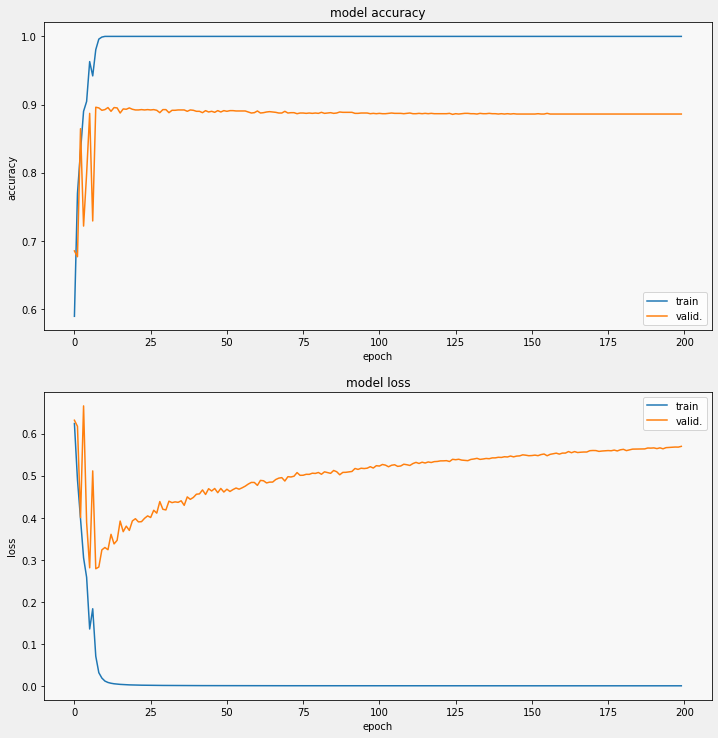

In [ ]:
def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])


print(reid_results.history.keys())
display_training_curves(reid_results.history['accuracy'], reid_results.history['val_accuracy'], 'accuracy', 211)
display_training_curves(reid_results.history['loss'], reid_results.history['val_loss'], 'loss', 212)

0.9577290440245838


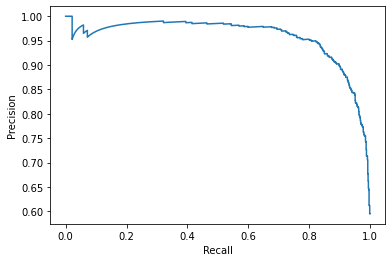

In [ ]:
### mAP Precision vs Recall 2048 ###

model = load_model('/content/drive/My Drive/Results/Market/open_reid_2048_small.h5')

labels_pred = []

for i in range(len(i_valid)):
  labels_pred.append(model.predict(np.expand_dims(i_valid[i], axis=0))[0][0])

labels_pred = np.array(labels_pred)

precision, recall, thresholds = precision_recall_curve(pair_labels_valid, labels_pred)

print(auc(recall, precision))

plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

0.9322582728330552


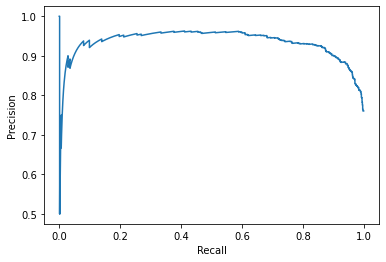

In [ ]:
### mAP Precision vs Recall 1024 ###

model = load_model('/content/drive/My Drive/Results/Market/open_reid_1024_small.h5')

cena1 = np.expand_dims(i1_valid, axis=0)
cena2 = np.expand_dims(i2_valid, axis=0)

labels_pred = model.predict([cena1, cena2])[0]

labels_pred = labels_pred.tolist()

for i in range(len(labels_pred)):
  labels_pred[i] = labels_pred[i][0]
    
labels_pred = np.array(labels_pred)

precision, recall, thresholds = precision_recall_curve(pair_labels_valid, labels_pred)

print(auc(recall, precision))

plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [ ]:
query_list = []
gallery_list = []

x_classes = []
labels_classes = []

for j in range(1, 1502):
  aux_x = []
  aux_labels = []
  for i in range(len(labels)):
    if labels[i] == j:
      aux_x.append(feat_vect[i])
      aux_labels.append(labels[i])
  x_classes.append(aux_x)
  labels_classes.append(aux_labels)

for i in range(1501):
  rand = random.randint(0, len(labels_classes[i])-1)
  gallery_list.append([labels_classes[i][rand], x_classes[i][rand]])

randomlist = random.sample(range(0, 1501), 100)

for i in randomlist:
  rand = random.randint(0,len(labels_classes[i])-1)
  query_list.append([labels_classes[i][rand], x_classes[i][rand]])

In [ ]:
def cmc_curve_2048(querys, gallery, topk):
    aux = 0
    ret = np.zeros(topk)
    valid_queries = 0
    all_rank = []
    sum_rank = np.zeros(topk)
    for query in querys:
        aux += 1
        print(aux)
        q_id = query[0]
        q_feature = query[1]
        # Calculate the distances for each query
        distmat = []
        for label, feature in gallery:
            #dist = np.linalg.norm(q_feature - feature)
            dist = model.predict(np.expand_dims(np.concatenate((q_feature, feature), axis=0), axis=0))
            distmat.append([dist, label])

        # Sort the results for each query
        distmat.sort(reverse=True)
        # Find matches
        matches = np.zeros(len(distmat))
        # Zero if no match 1 if match
        for i in range(0, len(distmat)):
            if distmat[i][1] == q_id:
                # Match found
                matches[i] = 1
        rank = np.zeros(topk)
        for i in range(0, topk):
            if matches[i] == 1:
                rank[i] = 1
                # If 1 is found then break as you dont need to look further path k
                break
        all_rank.append(rank)
        valid_queries +=1
    #print(all_rank)
    sum_all_ranks = np.zeros(len(all_rank[0]))
    for i in range(0,len(all_rank)):
        my_array = all_rank[i]
        for g in range(0, len(my_array)):
            sum_all_ranks[g] = sum_all_ranks[g] + my_array[g]
    sum_all_ranks = np.array(sum_all_ranks)
    print("NPSAR", sum_all_ranks)
    cmc_restuls = np.cumsum(sum_all_ranks) / valid_queries
    print(cmc_restuls)
    return cmc_restuls, sum_all_ranks


def cmc_curve_1024(querys, gallery, topk):
    aux = 0
    ret = np.zeros(topk)
    valid_queries = 0
    all_rank = []
    sum_rank = np.zeros(topk)
    for query in querys:
        aux += 1
        print(aux)
        q_id = query[0]
        q_feature = query[1]
        # Calculate the distances for each query
        distmat = []
        for label, feature in gallery:
            #dist = np.linalg.norm(q_feature - feature)
            dist = model.predict([np.expand_dims(q_feature, axis=0), np.expand_dims(feature, axis=0)])
            distmat.append([dist, label])

        # Sort the results for each query
        distmat.sort(reverse=True)
        # Find matches
        matches = np.zeros(len(distmat))
        # Zero if no match 1 if match
        for i in range(0, len(distmat)):
            if distmat[i][1] == q_id:
                # Match found
                matches[i] = 1
        rank = np.zeros(topk)
        for i in range(0, topk):
            if matches[i] == 1:
                rank[i] = 1
                # If 1 is found then break as you dont need to look further path k
                break
        all_rank.append(rank)
        valid_queries +=1
    #print(all_rank)
    sum_all_ranks = np.zeros(len(all_rank[0]))
    for i in range(0,len(all_rank)):
        my_array = all_rank[i]
        for g in range(0, len(my_array)):
            sum_all_ranks[g] = sum_all_ranks[g] + my_array[g]
    sum_all_ranks = np.array(sum_all_ranks)
    print("NPSAR", sum_all_ranks)
    cmc_restuls = np.cumsum(sum_all_ranks) / valid_queries
    print(cmc_restuls)
    return cmc_restuls, sum_all_ranks

In [ ]:
#Calculate mAP
def calculate_map(sum_ranks, n):
  sum = 0
  for i in range(len(sum_ranks)):
    sum += sum_ranks[i]/(i+1)
  map = (1/n)*sum
  print(map)

  return map

In [ ]:
model = load_model('/content/drive/My Drive/Results/Market/close_reid_2048.h5')
cmc_re_2048, sum_ranks_2048 = cmc_curve_2048(query_list, gallery_list, len(gallery_list))
map_2048 = calculate_map(sum_ranks_2048, len(query_list))

model = load_model('/content/drive/My Drive/Results/Market/close_reid_1024.h5')
cmc_re_1024, sum_ranks_1024 = cmc_curve_1024(query_list, gallery_list, len(gallery_list))
map_1024 = calculate_map(sum_ranks_1024, len(query_list))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
NPSAR [55. 12. 10.  6.  4.  2.  1.  1.  0.  0.  1.  0.  0.  0.  1.  0.  0.  1.
  0.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 

In [ ]:
print(cmc_re_2048[:30])
print(cmc_re_1024[:30])

[0.29 0.46 0.57 0.61 0.66 0.67 0.68 0.7  0.71 0.72 0.74 0.76 0.77 0.79
 0.81 0.81 0.82 0.82 0.84 0.85 0.87 0.87 0.88 0.88 0.88 0.89 0.9  0.9
 0.9  0.9 ]
[0.16 0.28 0.39 0.48 0.52 0.54 0.57 0.61 0.62 0.67 0.68 0.69 0.71 0.73
 0.78 0.81 0.82 0.83 0.83 0.84 0.85 0.85 0.86 0.86 0.86 0.87 0.88 0.88
 0.88 0.88]


In [ ]:
pickle_out = open("/content/drive/My Drive/Results/Market/cmc_re_close_2048.pickle","wb")
pickle.dump(cmc_re_2048, pickle_out)
pickle_out.close()

pickle_out = open("/content/drive/My Drive/Results/Market/cmc_re_close_1024.pickle","wb")
pickle.dump(cmc_re_1024, pickle_out)
pickle_out.close()

In [ ]:
pickle_in = open("/content/drive/My Drive/Results/Market/cmc_re_close_2048.pickle","rb")
cmc_re_2048 = pickle.load(pickle_in)

pickle_in = open("/content/drive/My Drive/Results/Market/cmc_re_close_1024.pickle","rb")
cmc_re_1024 = pickle.load(pickle_in)

pickle_in = open("/content/drive/My Drive/Results/Market/cmc_re_open_2048.pickle","rb")
cmc_re_2048_ = pickle.load(pickle_in)

pickle_in = open("/content/drive/My Drive/Results/Market/cmc_re_open_1024.pickle","rb")
cmc_re_1024_ = pickle.load(pickle_in)

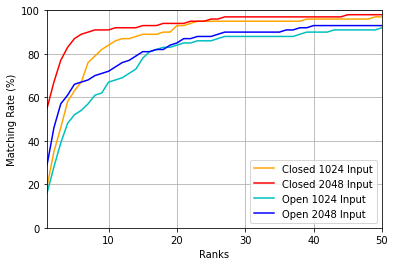

In [ ]:
cmc_re_2048 = cmc_re_2048[:50]
cmc_re_1024 = cmc_re_1024[:50]

cmc_re_2048_ = cmc_re_2048_[:50]
cmc_re_1024_ = cmc_re_1024_[:50]

ranks = [a for a in range(1,51)]

plt.plot(ranks, 100*cmc_re_1024, 'orange', label='Closed 1024 Input')
plt.plot(ranks, 100*cmc_re_2048, 'r', label='Closed 2048 Input')
plt.plot(ranks, 100*cmc_re_1024_, 'c', label='Open 1024 Input')
plt.plot(ranks, 100*cmc_re_2048_, 'b', label='Open 2048 Input')
plt.xlabel('Ranks')
plt.ylabel('Matching Rate (%)')
plt.axis([1, 50, 0, 100])
plt.grid()
plt.legend()
plt.show()